### Weather Data Prep

Origin: 
- https://data.open-power-system-data.org/weather_data/

Citation:
- Open Power System Data. 2020. Data Package Weather Data. Version 2020-09-16. https://doi.org/10.25832/weather_data/2020-09-16. (Primary data from various sources, for a complete list see URL).

Setup

In [3]:
import missingno
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import numpy as np

# Multiple outputs per notebook cell
%config InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
# Functions
def country_level_variables(df, load_only=False):
    '''
    Description: Seperates dataframe in country level dataframes 
    according to the first two letters of the variable.
    '''
    # Get all unique two-letter prefixes
    countries = set(col[:2] for col in df.columns if col not in ['utc_timestamp', 'cet_cest_timestamp'])
    
    # Dictionary to store results
    group_dfs = {}
    
    if load_only:
        for country in countries:
            # Load actual variable
            load_only_var = country + '_load_actual_entsoe_transparency'

            # Variables to subset to
            all_cols = ['utc_timestamp', load_only_var]
            
            # Create dataframe for country and assign to dictionary
            group_df = df[all_cols].copy() 
            group_dfs[country] = pd.DataFrame(group_df)
            
            # Create global variable for each group
            globals()[country] = group_df

    else:
        # Create dataframe for each prefix
        for country in countries:
            # Get columns that start with the prefix
            country_cols = [col for col in df.columns if col.startswith(country)]
            
            # Add time variables
            time_col = ['utc_timestamp']
            all_cols = time_col + country_cols
            
            # Create dataframe for country and assign to dictionary
            group_df = df[all_cols].copy() 
            group_dfs[country] = pd.DataFrame(group_df)
            
            # Create global variable for each group
            globals()[country] = group_df
    
    return group_dfs #pd.DataFrame(group_dfs)

def country_missing_dt(country_dfs):
    '''
    Description: Create missing data plots per country
    '''
    for country, data in country_dfs.items():
        # Ensure data is ordered
        data = data.sort_values(by='utc_timestamp')
        # Return missing data for given country
        print(f"Country: {country} has {data.shape[1]} columns")
        missingno.matrix(data, figsize=(8,5), fontsize=10)

Data Prep

In [ ]:
cd = Path.cwd()
data_dir = str(cd.parents[1])

weather_dt = (pd.read_csv(data_dir + "/datasets/country_energy/weather_data.csv")
                # 2015 forward
                .loc[lambda x: x.utc_timestamp >= '2015-01-01'])
weather_dt.head()

,utc_timestamp,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
306816,2015-01-01T00:00:00Z,-6.503,0.0,0.0,-0.046,0.0,0.0,-13.350,0.0,0.0,...,0.0,0.690,0.0,0.0,-11.261,0.0,0.0,-8.272,0.0,0.0
306817,2015-01-01T01:00:00Z,-6.458,0.0,0.0,-0.302,0.0,0.0,-13.594,0.0,0.0,...,0.0,0.786,0.0,0.0,-10.975,0.0,0.0,-8.114,0.0,0.0
306818,2015-01-01T02:00:00Z,-6.253,0.0,0.0,-0.541,0.0,0.0,-13.781,0.0,0.0,...,0.0,0.946,0.0,0.0,-10.772,0.0,0.0,-7.898,0.0,0.0
306819,2015-01-01T03:00:00Z,-5.908,0.0,0.0,-0.794,0.0,0.0,-14.042,0.0,0.0,...,0.0,1.160,0.0,0.0,-10.667,0.0,0.0,-7.670,0.0,0.0
306820,2015-01-01T04:00:00Z,-5.516,0.0,0.0,-1.053,0.0,0.0,-14.340,0.0,0.0,...,0.0,1.382,0.0,0.0,-10.467,0.0,0.0,-7.399,0.0,0.0


Check for completeness of data at the country level

Country: LU has 4 columns
Country: NL has 4 columns
Country: BE has 4 columns
Country: HU has 4 columns
Country: DE has 4 columns
Country: AT has 4 columns


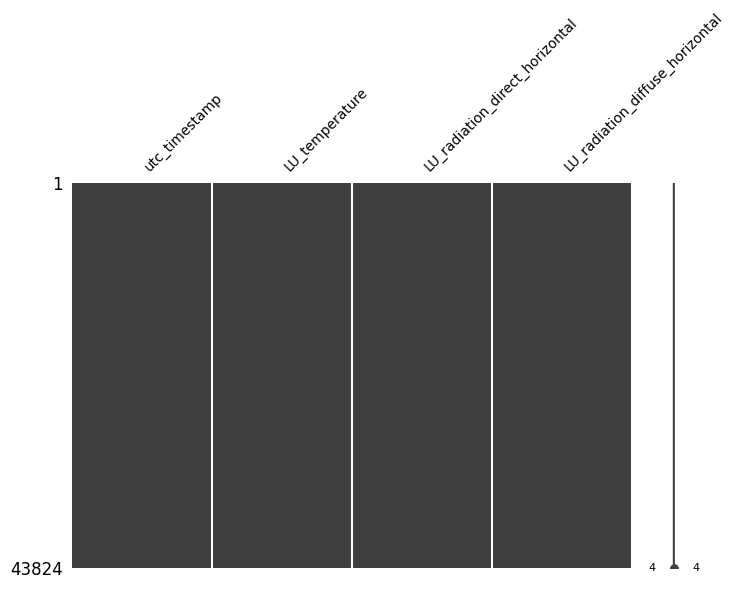

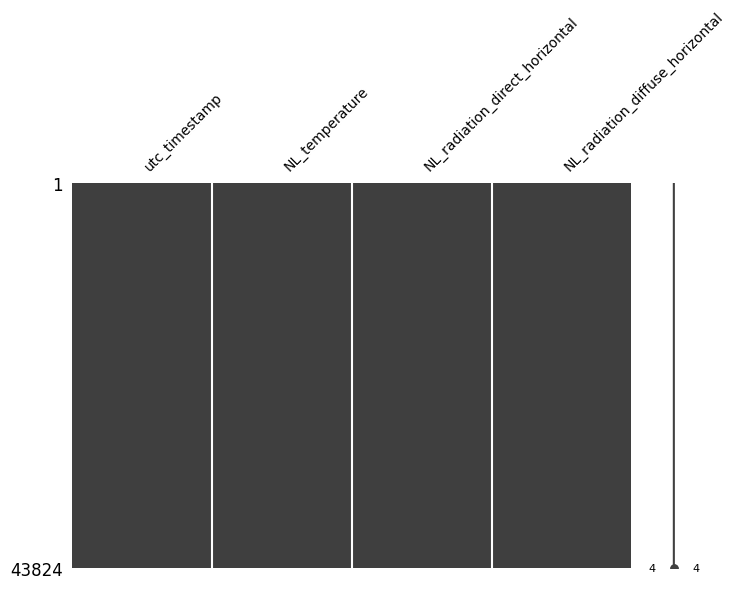

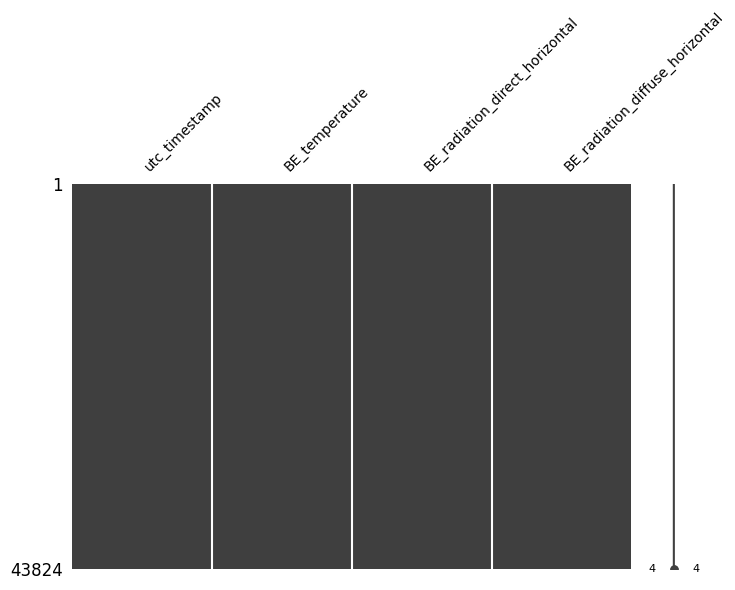

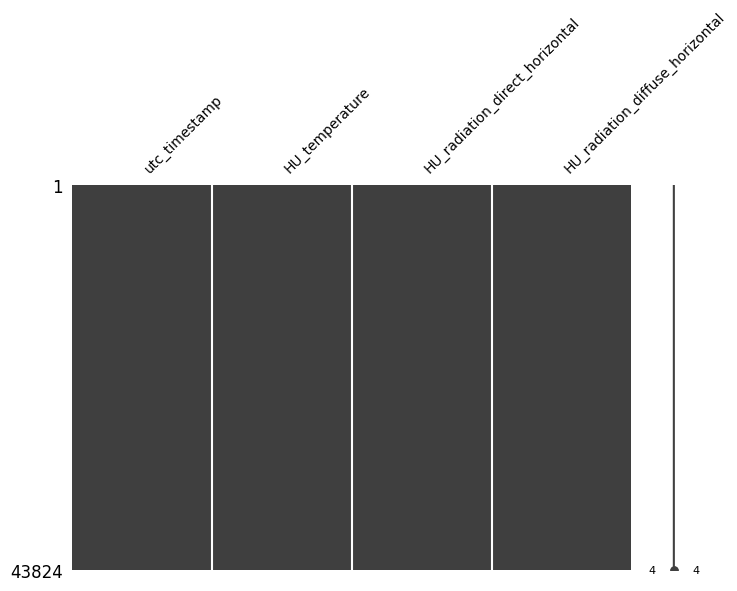

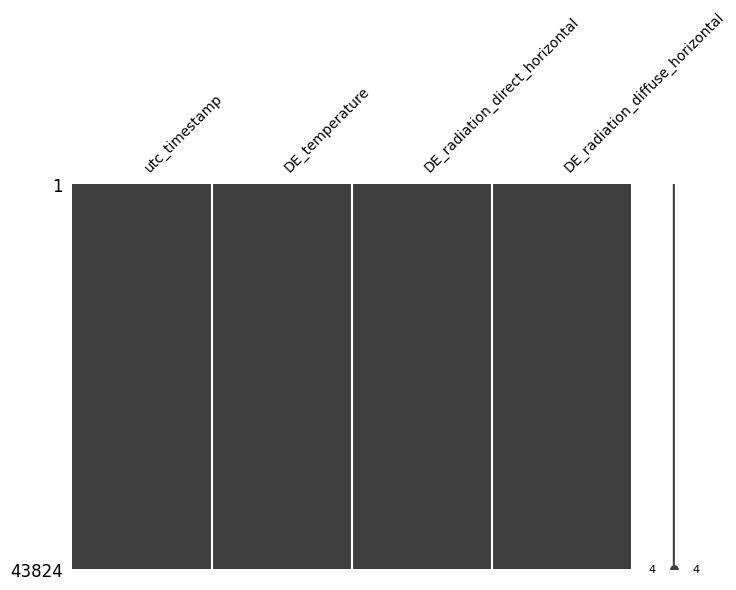

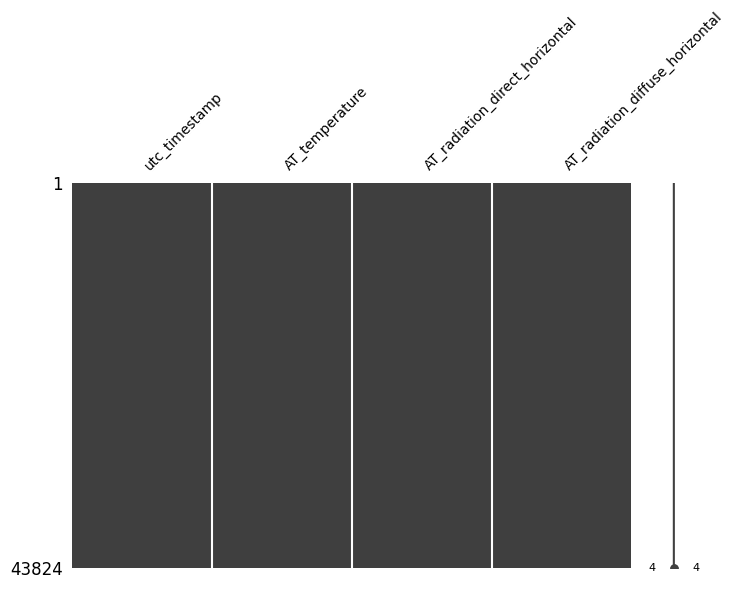

In [6]:
# Seperate dataframe to dictionary with countries and associated variables
all_country_wthr = country_level_variables(weather_dt)

# subset to countries with 15 minute interval data
country_wthr = {k: all_country_wthr[k] for k in ['LU', 'NL', 'BE', 'HU', 'DE', 'AT']}
country_missing_dt(country_wthr)

Select Variables, Pivot

In [7]:
# Select variables and pivot by country
pivot_country_weather = pd.DataFrame({})

for abbreviation, data in country_wthr.items():
    # Country level variables
    temp = abbreviation + '_temperature'
    radi_direct = abbreviation + '_radiation_direct_horizontal'
    radi_diffuse = abbreviation + '_radiation_diffuse_horizontal'

    # New dataframe with timestamp, country, and load_actual
    data = (data.assign(utc_timestamp = pd.to_datetime(data.utc_timestamp),
                        country = abbreviation)
                .rename(columns = {temp: 'temp',
                                   radi_direct: 'radiation_direct_horizontal',
                                   radi_diffuse: 'radiation_diffuse_horizontal'})
                [['utc_timestamp', 'country', 'temp', 'radiation_direct_horizontal', 'radiation_diffuse_horizontal']]) 
    # Concat
    pivot_country_weather = pd.concat([pivot_country_weather, data])


Add daily stats, HDD, and CDD

In [8]:
# Aggregate for daily stats
pivot_country_weather = pivot_country_weather.reset_index(drop=True)
pivot_country_weather['day'] = pivot_country_weather['utc_timestamp'].dt.date
day_mean_temp = (pivot_country_weather.groupby('day', as_index=False)
                                      .agg(mean_temp = ('temp', 'mean'),
                                           max_temp = ('temp', 'max'),
                                           min_temp = ('temp', 'min')))

# Create hdd and cdd variables
pivot_country_weather_2 = (pivot_country_weather.merge(day_mean_temp, how='left', on='day')
                                                .assign(hdd = lambda x: np.where(15.5 - x.temp > 0, 1, 0),
                                                        cdd = lambda x: np.where(x.temp - 15.5 > 0, 1, 0)))
pivot_country_weather_2

,utc_timestamp,country,temp,radiation_direct_horizontal,radiation_diffuse_horizontal,day,mean_temp,max_temp,min_temp,hdd,cdd
0,2015-01-01 00:00:00+00:00,LU,-1.983,0.0,0.0,2015-01-01,-1.119535,3.298,-8.399,1,0
1,2015-01-01 01:00:00+00:00,LU,-2.083,0.0,0.0,2015-01-01,-1.119535,3.298,-8.399,1,0
2,2015-01-01 02:00:00+00:00,LU,-2.075,0.0,0.0,2015-01-01,-1.119535,3.298,-8.399,1,0
3,2015-01-01 03:00:00+00:00,LU,-2.234,0.0,0.0,2015-01-01,-1.119535,3.298,-8.399,1,0
4,2015-01-01 04:00:00+00:00,LU,-2.323,0.0,0.0,2015-01-01,-1.119535,3.298,-8.399,1,0
...,...,...,...,...,...,...,...,...,...,...,...
262939,2019-12-31 19:00:00+00:00,AT,-1.386,0.0,0.0,2019-12-31,1.027826,6.492,-3.153,1,0
262940,2019-12-31 20:00:00+00:00,AT,-1.661,0.0,0.0,2019-12-31,1.027826,6.492,-3.153,1,0
262941,2019-12-31 21:00:00+00:00,AT,-1.986,0.0,0.0,2019-12-31,1.027826,6.492,-3.153,1,0
262942,2019-12-31 22:00:00+00:00,AT,-2.184,0.0,0.0,2019-12-31,1.027826,6.492,-3.153,1,0


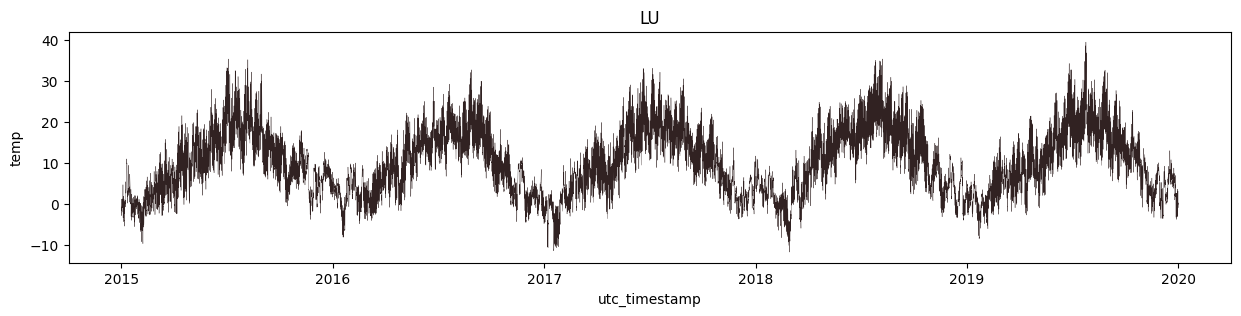

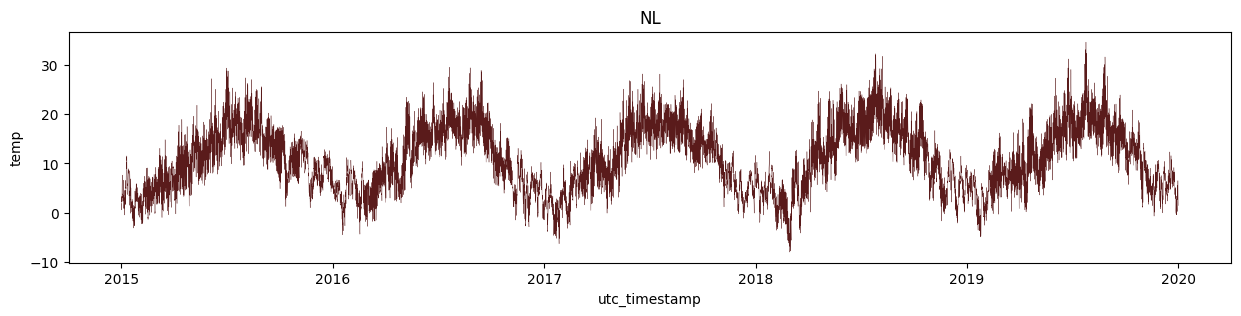

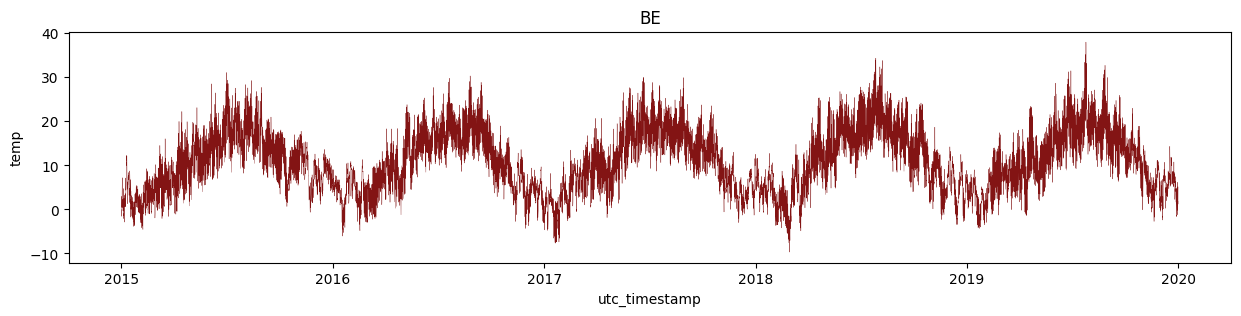

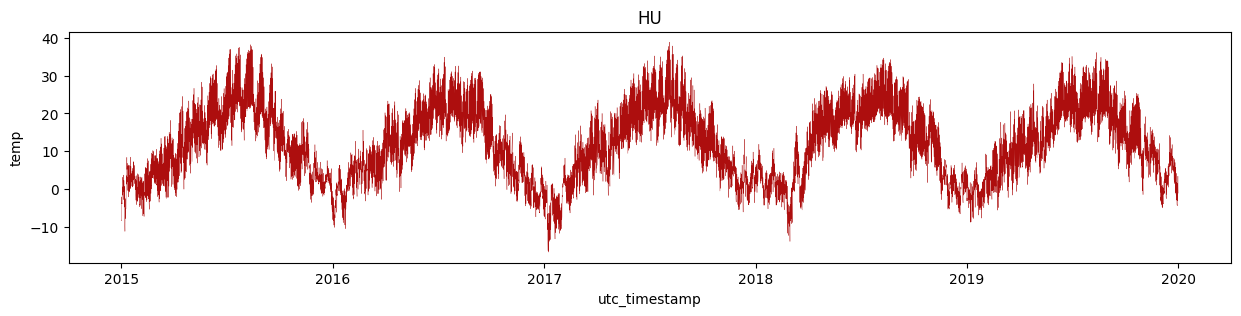

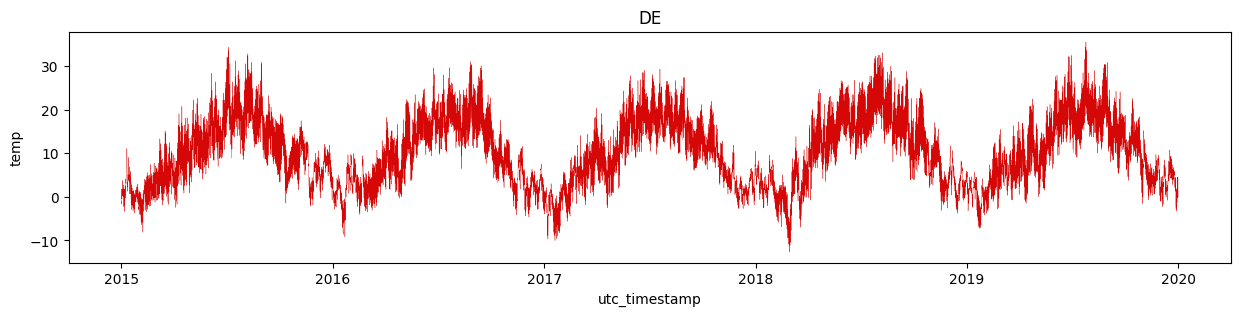

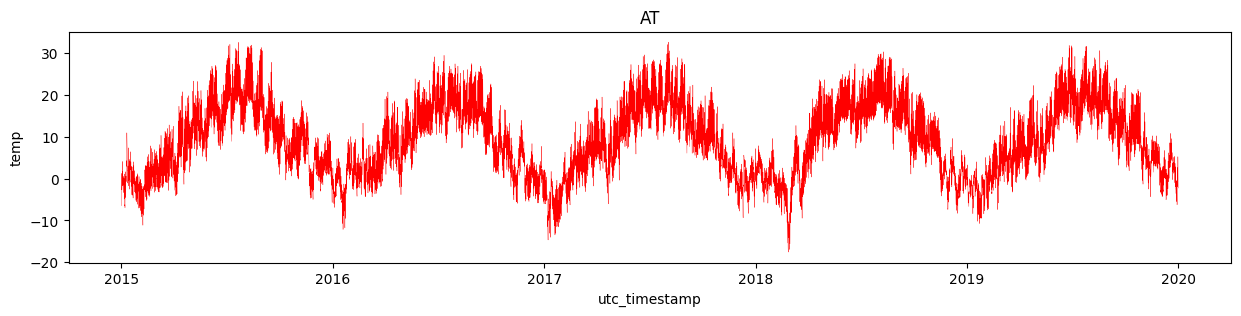

In [9]:
# Colors and Countries for TS plots
colors = ['#D91A1A', '#B41C1C', '#8F1D1E', '#6B1F20', '#462022', '#212224']
all_countries = country_wthr.keys()
palette = sns.color_palette("dark:red", len(all_countries)) # mako # magma

# Create TS plot for each country 
for country, color in zip(all_countries, palette):  
    plot_dt = pivot_country_weather.loc[lambda x: x.country == country]
    _ = plt.figure(figsize=(15, 3))

    _ = sns.lineplot(
        data=plot_dt, 
        x='utc_timestamp', 
        y='temp', 
        color=color,
        linewidth=0.25)
    _ = plt.title(country)

    plt.show()

Save Data

In [11]:
# Save dictionary data and pivoted data
wthr_file_path_1 = data_dir + '/datasets/country_energy/pivot_country_weather.pickle'
with open(wthr_file_path_1, 'wb') as file:
    pickle.dump(pivot_country_weather_2, file, protocol=pickle.HIGHEST_PROTOCOL)

wthr_file_path_2 = data_dir + '/datasets/country_energy/country_weather.pickle'
with open(wthr_file_path_2, 'wb') as file:
    pickle.dump(country_wthr, file, protocol=pickle.HIGHEST_PROTOCOL)